#**Assessing similarities between spatial point patterns with a Siamese neural network discriminant model**

# One Shot Learning: a Simulation Study

##Reading data

In [1]:
# mounting my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import feather

# path to the data directory
path = '/content/drive/My Drive/simPatterns'
os.chdir(path)
#!ls
#os.listdir(path)

# number of groups (species, processes, ...)
n_classes = 10
# number of replicates (censuses, ...)
n_examples = 10

# rectangular observation window
xmin = 0
xmax = 1
ymin = 0
ymax = 1
window = [[xmin, xmax], [ymin, ymax]]

# grid dimension
grid_nx = 128
grid_ny = 128

In [0]:
# read data files: each point pattern is in a separate file 
process = ["Poisson", "LGCP", "Thomas", "MatClust", "VarGamma", 
           "Cauchy", "dppG", "dppC", "Strauss", "AreaInter"]
sim_patterns = [None] * n_classes
filename = [None] * n_examples
for i in range(n_classes):
  sim_patterns[i] = [None] * n_examples
  for j in range(n_examples):
    filename[j] = process[i] + str(j + 1) + ".feather"
    df = feather.read_dataframe(filename[j])
    sim_patterns[i][j] = df

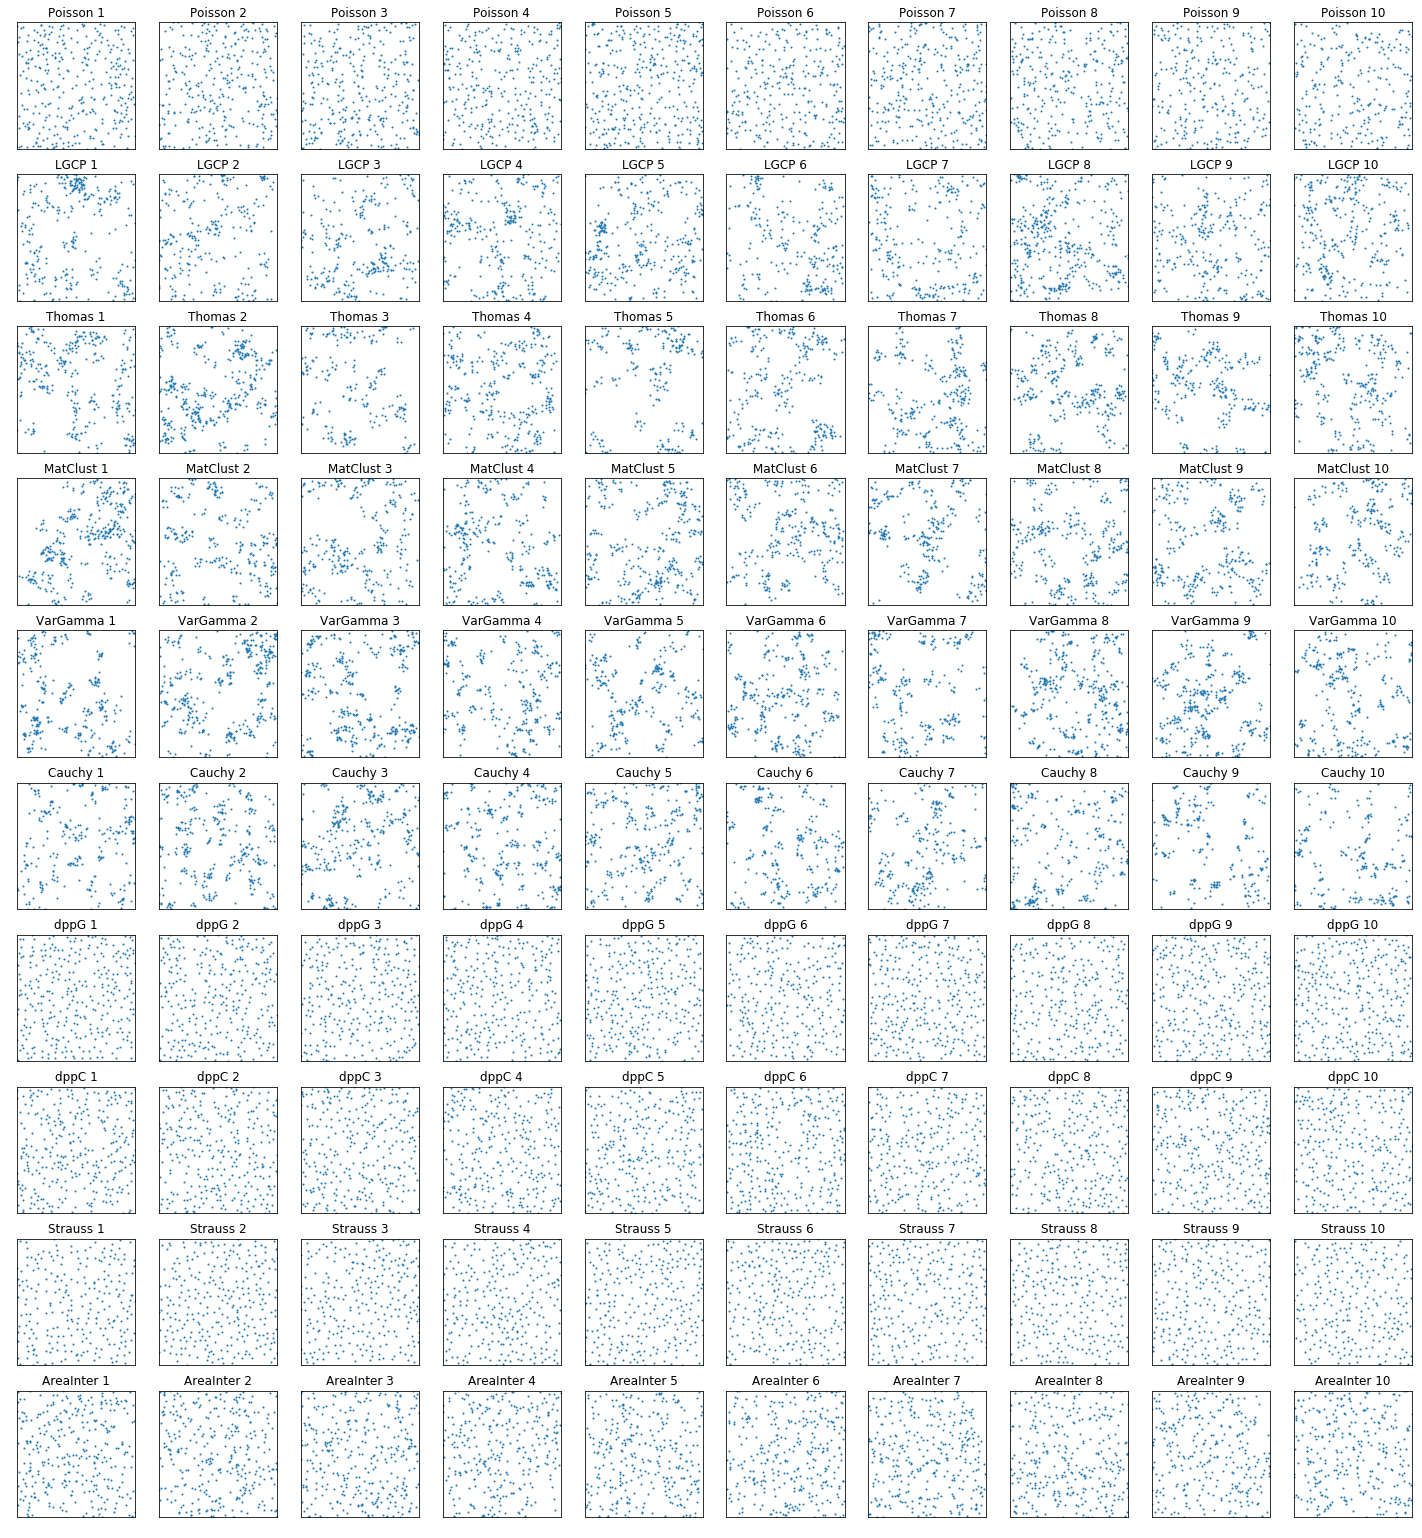

In [4]:
fig, axs = plt.subplots(10, 10, figsize=(25, 27.5))

for i in range(n_classes):
  for j in range(n_examples):
    axs[i, j].scatter(sim_patterns[i][j]['x'], sim_patterns[i][j]['y'], s=1)
    axs[i, j].set_title(process[i] + ' ' + str(j + 1))
    axs[i, j].set_xlim([0, 1])
    axs[i, j].set_ylim([0, 1])
    #axs[i, j].axis('off')
    axs[i, j].set_xticks([0, 1])
    axs[i, j].set_yticks([0, 1])
    axs[i, j].tick_params(axis='both', which='both',length=0, labelcolor='white')

#fig.savefig('simpatterns.pdf', bbox_inches='tight')

## Convert spatial point patterns to images (spatial counts)

In [5]:
def pattern2img(pp, nx, ny, window):
  x = pp['x']
  y = pp['y']
  grid = np.histogram2d(x, y, bins=[nx, ny], range=window, density=False)[0]
  return np.transpose(grid)

sim_imgs = [None] * n_classes
for i in range(n_classes):
  sim_imgs[i] = [None] * n_examples
  for j in range(n_examples):
    sim_imgs[i][j] = pattern2img(sim_patterns[i][j], grid_nx, grid_ny, window)

sim_imgs = np.asarray(sim_imgs)
print(sim_imgs.shape)
print(sim_imgs.mean())
print(sim_imgs.max())

(10, 10, 128, 128)
0.018201904296875
3.0


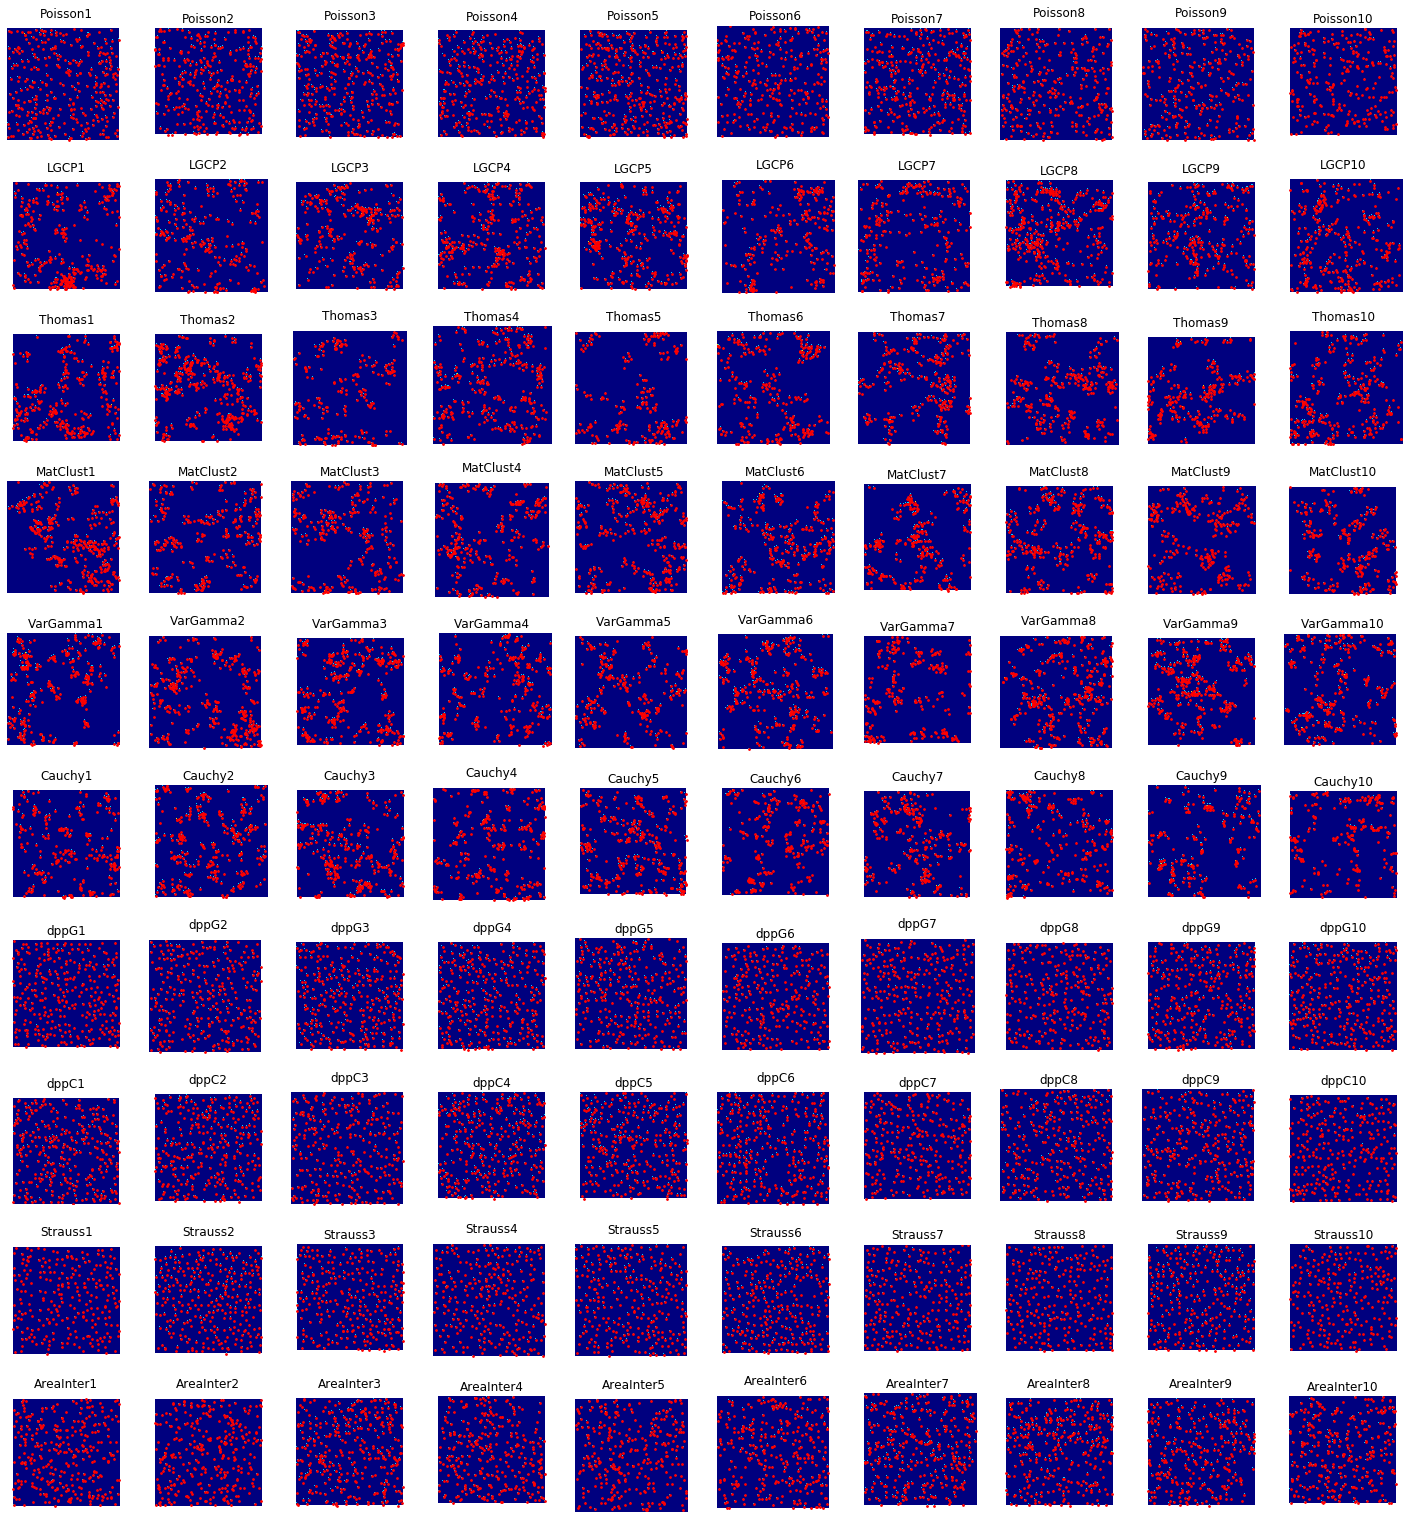

In [6]:
fig, axs = plt.subplots(10, 10, figsize=(25, 27.5))

for i in range(n_classes):
  for j in range(n_examples):
    axs[i, j].imshow(sim_imgs[i][j], vmin=0, vmax=sim_imgs.max(), cmap='jet')
    axs[i, j].scatter(sim_patterns[i][j]['x'] * grid_nx, 
                      sim_patterns[i][j]['y'] * grid_ny, s=3, color='red')
    axs[i, j].set_title(process[i] + str(j + 1))
    axs[i, j].axis('off')
#fig.savefig('simimgs.pdf', bbox_inches='tight')

In [7]:
print(np.sum(sim_imgs, axis=(2, 3)))

[[326. 307. 322. 309. 357. 296. 322. 302. 279. 265.]
 [300. 251. 269. 306. 330. 254. 268. 405. 278. 318.]
 [307. 383. 209. 325. 219. 275. 286. 311. 261. 303.]
 [362. 285. 280. 301. 339. 292. 279. 319. 302. 270.]
 [305. 379. 368. 298. 284. 325. 262. 388. 368. 304.]
 [269. 334. 339. 309. 328. 285. 278. 298. 234. 235.]
 [308. 295. 297. 287. 296. 274. 307. 271. 304. 311.]
 [305. 300. 294. 297. 289. 311. 279. 283. 297. 283.]
 [251. 284. 267. 275. 273. 273. 262. 258. 260. 253.]
 [316. 317. 329. 303. 308. 312. 323. 315. 292. 301.]]


## Computing intensity and K functions with 'spatstat'

In [8]:
# install the R package spatstat: only once
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages('spatstat')

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependencies ‘spatstat.data’, ‘spatstat.utils’, ‘deldir’, ‘abind’, ‘tensor’, ‘polyclip’, ‘goftest’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/spatstat.data_1.4-3.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2865112 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/di

rpy2.rinterface.NULL

In [0]:
import rpy2.robjects.packages as packages
# load spatstat
spatstat = importr('spatstat')
#from spatstat import *

import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [10]:
sim_rhos = [None] * n_classes
sim_Ks = [None] * n_classes
sim_Ks2 = [None] * n_classes
r = np.arange(0, 0.15, 0.00025)
for i in range(n_classes):
  sim_rhos[i] = [None] * n_examples
  sim_Ks[i] = [None] * n_examples
  sim_Ks2[i] = [None] * n_examples
  for j in range(n_examples):
    pp = spatstat.ppp(sim_patterns[i][j]['x'], sim_patterns[i][j]['y'])
    dd = spatstat.adaptive_density(pp)
    sim_rhos[i][j] = np.array(dd.rx2('v'))
    kk = spatstat.Kest(pp, r=r, correction='translation').rx2('trans')
    sim_Ks[i][j] = np.array(kk)
    kk2 = spatstat.Kinhom(pp, dd, r=r, correction='translation').rx2('trans')
    #kk2 = np.array(kk2)
    sim_Ks2[i][j] = np.array(kk2)

sim_rhos = np.asarray(sim_rhos)
sim_Ks = np.asarray(sim_Ks)
sim_Ks2 = np.asarray(sim_Ks2)

print(sim_rhos.shape)
print(sim_Ks.shape)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
     PLEASE NOTE:  The components "delsgs" and "summary" of the
 object returned by deldir() are now DATA FRAMES rather than
 matrices (as they were prior to release 0.0-18).
 See help("deldir").
 
     PLEASE NOTE: The process that deldir() uses for determining
 duplicated points has changed from that used in version
 0.0-9 of this package (and previously). See help("deldir").



  warnings.warn(x, RRuntimeWarning)


(10, 10, 128, 128)
(10, 10, 600)


In [11]:
# difference between estimates of K function under homogeneous and inhomogeneous assumptions
((sim_Ks2 - sim_Ks)**2).mean()

0.00013398727183908004

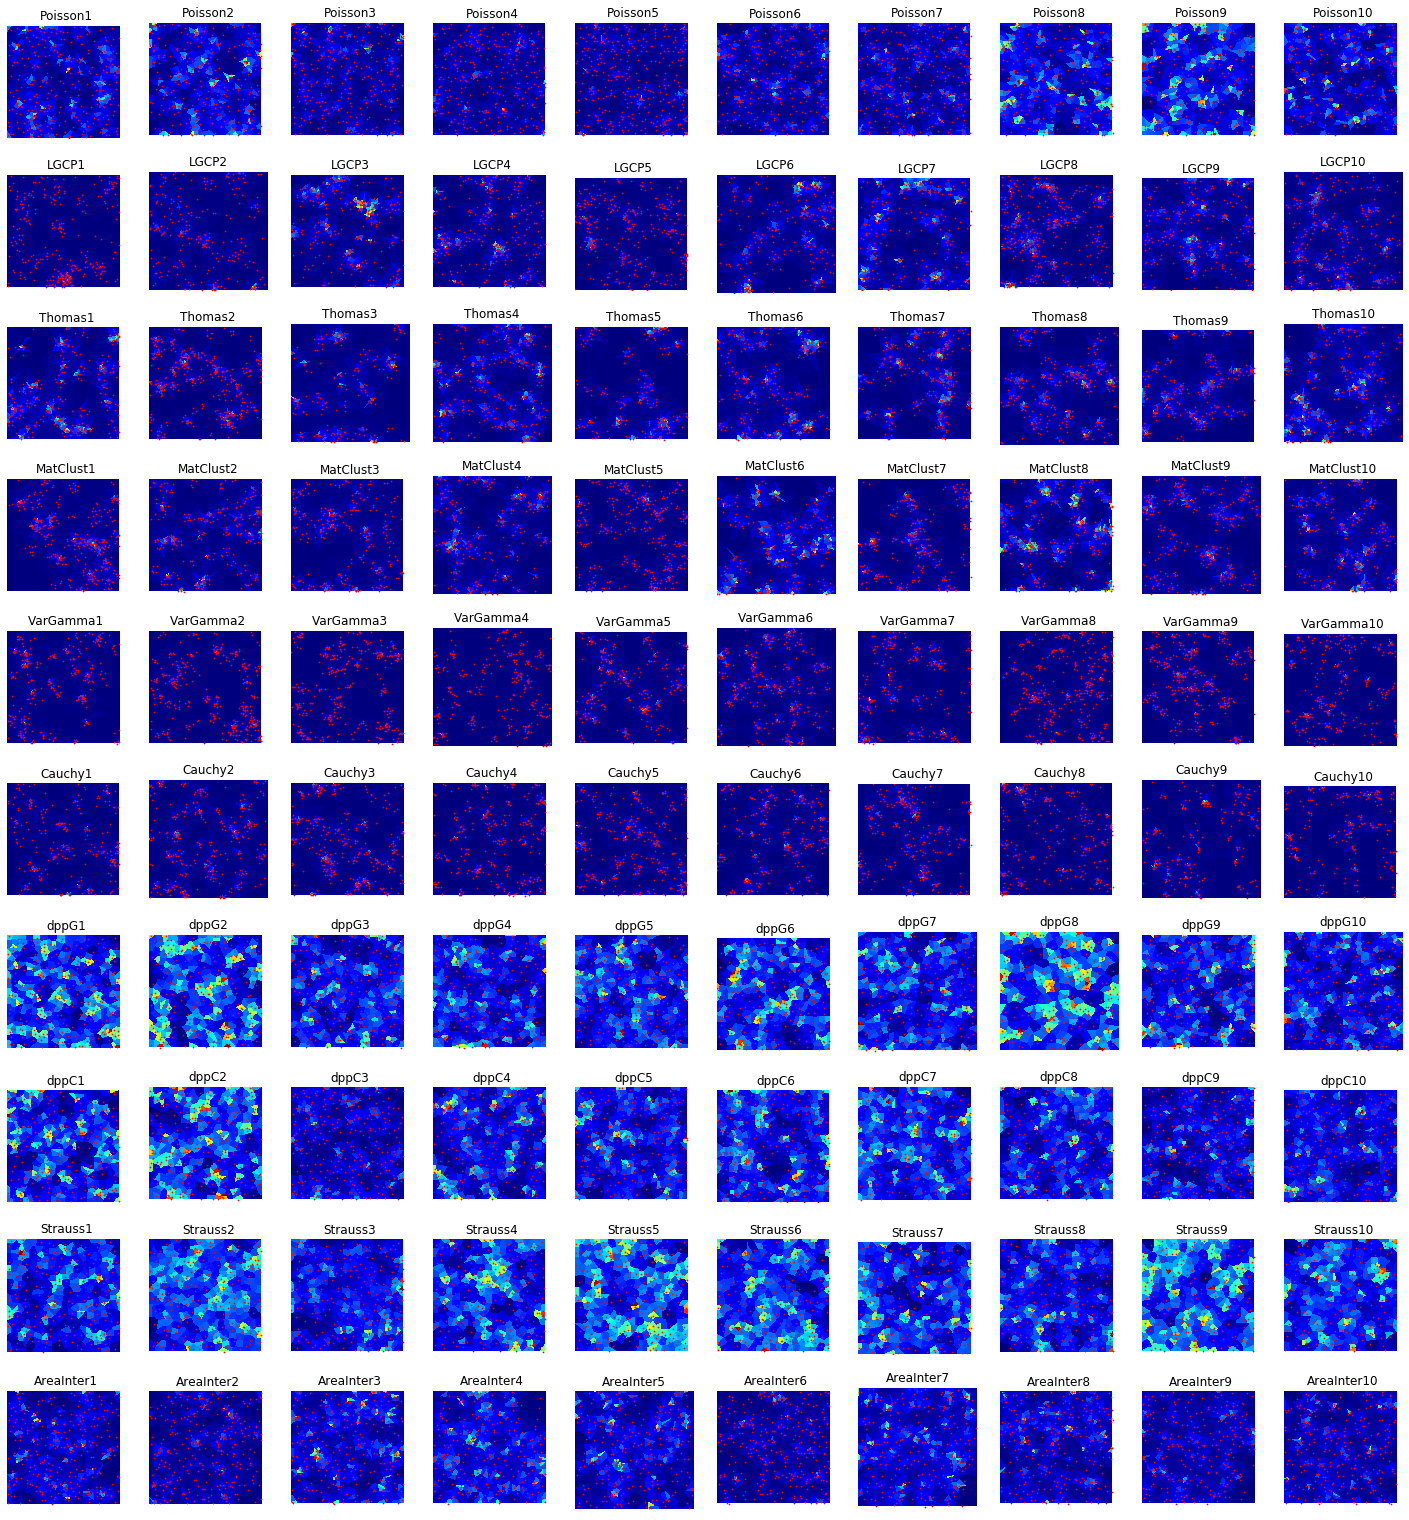

In [12]:
fig, axs = plt.subplots(10, 10, figsize=(25, 27.5))

for i in range(n_classes):
  for j in range(n_examples):
    axs[i, j].imshow(sim_rhos[i][j],  cmap='jet') #vmin=0, vmax=sim_rhos.max(),
    axs[i, j].scatter(sim_patterns[i][j]['x'] * 128, 
                      sim_patterns[i][j]['y'] * 128, s=0.5, color='red')
    axs[i, j].set_title(process[i] + str(j + 1))
    axs[i, j].axis('off')
#fig.savefig('simrhos.pdf', bbox_inches='tight')

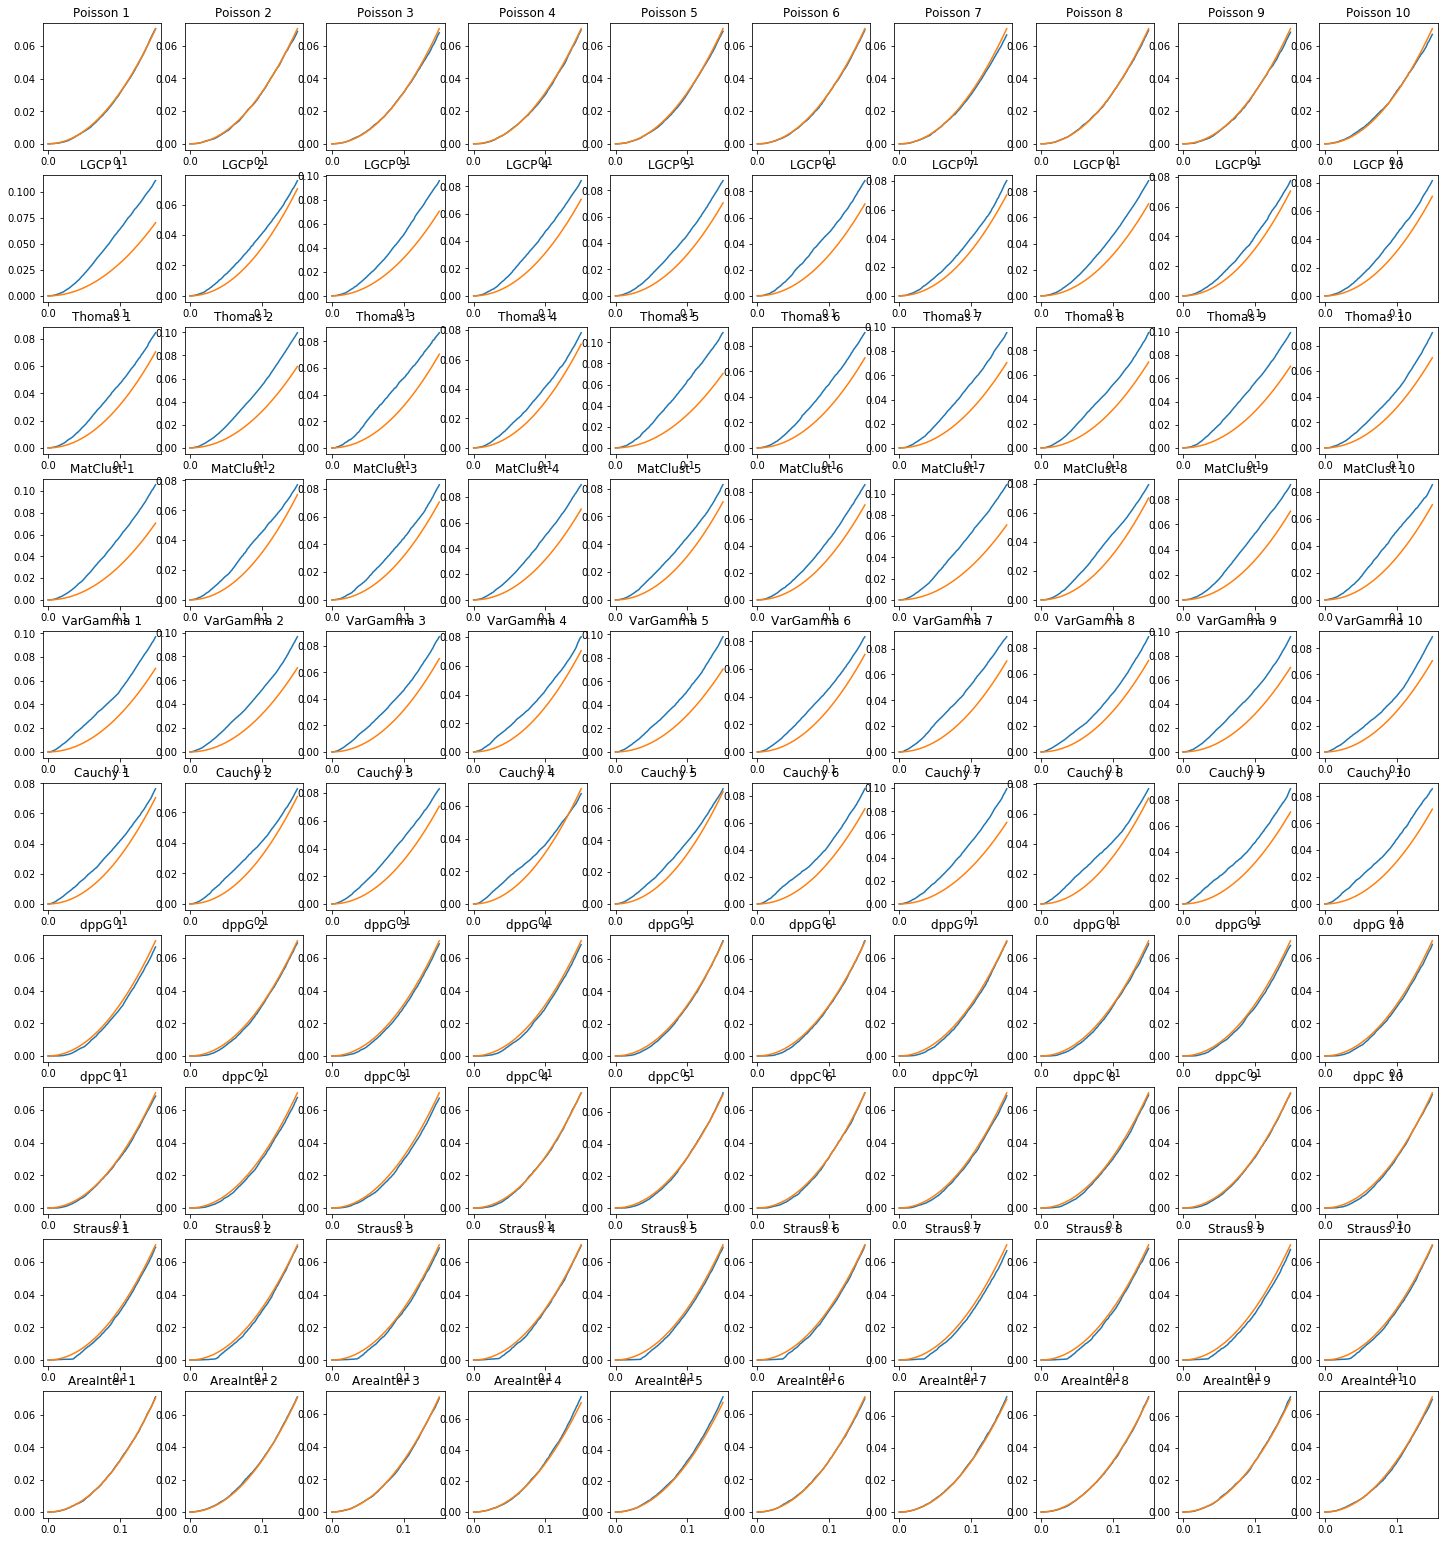

In [13]:
fig, axs = plt.subplots(10, 10, figsize=(25, 27.5))
for i in range(n_classes):
  for j in range(n_examples):
    axs[i, j].plot(r, sim_Ks[i][j]) # estimated K function
    axs[i, j].plot(r, np.pi * r**2) # theoretical K function for a Poisson process
    axs[i, j].set_title(process[i] + ' ' + str(j + 1))
#fig.savefig('simlogKfuns.pdf', bbox_inches='tight')

## Prepare traning and validation point patterns

In [14]:
X = sim_imgs / sim_imgs.max()
y = []
for i in range(n_classes * n_examples *  grid_nx * grid_ny): 
  y.append(int(i / (n_examples * grid_nx * grid_ny)))
y = np.asarray(y)
y = y.reshape([n_classes * n_examples * grid_nx * grid_ny, 1])
print(y.shape)

(1638400, 1)


In [15]:
import numpy.random as rng
n_test = 3

Xtrain = np.zeros([n_classes, n_examples - n_test, grid_ny, grid_nx])
Xval = np.zeros([n_classes, n_test, grid_ny, grid_nx])

for i in range(n_classes):
  val_idx = np.random.choice(n_examples, size=n_test, replace=False)
  Xtrain[i, :, :, :] = np.delete(X[i, :, :, :], val_idx, axis=0)
  Xval[i, :, :, :] = X[i, val_idx, :, :]

print(Xtrain.shape)
print(Xval.shape)

ytrain = []
for i in range(n_classes * (n_examples - n_test) *  grid_ny * grid_nx): 
  ytrain.append(int(i / ((n_examples - n_test) * grid_ny * grid_nx)))
ytrain = np.asarray(ytrain)
ytrain = ytrain.reshape([n_classes * (n_examples - n_test) * grid_ny * grid_nx, 1])
yval = []
for i in range(n_classes * n_test *  grid_ny * grid_nx): 
  yval.append(int(i / (n_test * grid_ny * grid_nx)))
yval = np.asarray(yval)
yval = yval.reshape([n_classes * n_test * grid_ny * grid_nx, 1])

print(ytrain.shape)
print(yval.shape)

(10, 7, 128, 128)
(10, 3, 128, 128)
(1146880, 1)
(491520, 1)


In [0]:
def get_batch(batch_size, s = "train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = Xtrain
        categories = ytrain
    else:
        X = Xval
        categories = yval
    n_c, n_e, h, w = X.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_c, size=(batch_size,), replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w, 1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size // 2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_e)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(h, w, 1)
        idx_2 = rng.randint(0, n_e)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1, n_c)) % n_c
        
        pairs[1][i, :, :, :] = X[category_2, idx_2].reshape(h, w, 1)
    
    return pairs, targets

## Siamese network

In [17]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
def make_oneshot_task(N, s="val"):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = ytrain
    else:
        X = Xval
        categories = yval
    n_classes, n_examples, h, w = X.shape
    
    categories = rng.choice(range(n_classes), size=(N,), replace=False)            
    indices = rng.randint(0, n_examples, size=(N,))
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1,:,:]] * N).reshape(N, h, w, 1)
    indices[0] = ex2
    support_set = X[categories, indices, :, :]
    #support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, h, w, 1)
    targets = np.zeros((N,))
    targets[0] = 1
   # targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    ## aj
    cat = categories
    ind = [ex1, indices]
    ## aj
    return pairs, targets, cat, ind

  
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k, N))
    for i in range(k):
        inputs, targets, __, __ = make_oneshot_task(N, s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

[0 4 3 5 4 0 1]
[3 6 5 2 0 4 8]
3
0


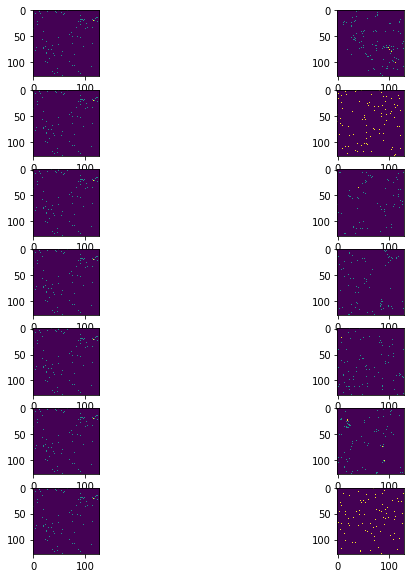

In [19]:
# one shot task: testing
iii = rng.randint(0, 6, size=(7,))
jjj = rng.choice(range(n_classes), size=(7,), replace=False) 
eii1, eii2 = rng.choice(6, replace=False, size=(2,))
print(iii)
print(jjj)
print(eii1)
print(eii2)
#
Xtrain[jjj[0], iii, :, :].shape
aaa = np.asarray([Xtrain[jjj[0], eii1,:,:]] * 7).reshape(7, grid_ny, grid_nx, 1)
aaa.shape
bbb = Xtrain[jjj, iii, :, :]
bbb[0, :, :] = Xtrain[jjj[0], eii2, :, :]
bbb = bbb.reshape(7, grid_ny, grid_nx, 1)
fig, axs = plt.subplots(7, 2, figsize=(10, 10))
for i in range(7):
  axs[i, 0].imshow(aaa[i, :, :, 0])
  axs[i, 1].imshow(bbb[i, :, :, 0])

In [20]:
a, b, c, d = make_oneshot_task(7)
c[1].shape == b.shape
d

[1, array([0, 2, 0, 1, 2, 2, 0])]

In [0]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(filters=8, kernel_size=(9, 9), strides=1, 
                     padding='valid', activation='relu', input_shape=input_shape,
                     kernel_regularizer=l2(5e-4), #bias_regularizer=l2(1e-2),
                     bias_initializer='zeros', kernel_initializer='glorot_uniform'
                     ))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='valid'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=1, 
                     padding='valid', activation='relu',
                     kernel_regularizer=l2(5e-4),  #bias_regularizer=l2(1e-2),
                     bias_initializer='zeros', kernel_initializer='glorot_uniform'
                      ))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='valid'))
#    model.add(Dropout(rate=0.1))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, 
                     padding='valid', activation='relu',
                     kernel_regularizer=l2(5e-4), #bias_regularizer=l2(1e-2),
                     bias_initializer='zeros', kernel_initializer='glorot_uniform'
                      ))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(256, activation='sigmoid', use_bias=True,
                    kernel_regularizer=l2(1e-4)#,
                    ))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # return the model
    return siamese_net

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


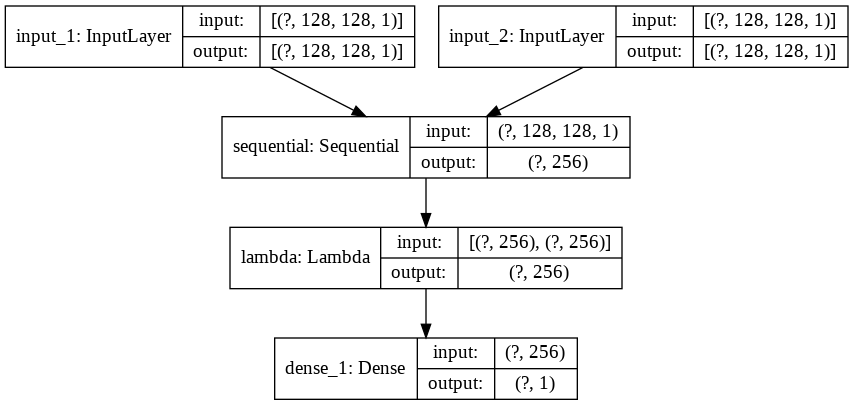

In [22]:
input_shape = (grid_ny, grid_nx, 1)
model = get_siamese_model(input_shape)
plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
optimizer =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          213568      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________


In [0]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
# reset_weights(model) # for multiple running
# model.get_weights()

In [25]:
import time

model_path = './weights/'

# Hyper parameters
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 10
n_iter = 5000 # No. of training iterations
N_way = 10 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

loss = np.zeros(n_iter)
val_acc, train_acc = [], []
val_index = 0
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(n_iter):
    (inputs, targets) = get_batch(batch_size)
    loss[i] = model.train_on_batch(inputs, targets)
    #if (i + 1) % 2 == 0:
    K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) * 0.99)
    if (i + 1) % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i + 1, (time.time() - t_start)/60.0))
        print("Train Loss: {0}".format(loss[i]))
        print("Learning Rate: {0}".format(K.eval(model.optimizer.lr)))
        val_acc.append(test_oneshot(model, N_way, n_val, verbose=True))
        train_acc.append(test_oneshot(model, N_way, n_val, s='train', verbose=True))
        #model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc[val_index] >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc[val_index], best))
            best = val_acc[val_index]
        val_index += 1

val_acc = np.array(val_acc)

Starting training process!
-------------------------------------

 ------------- 

Time for 100 iterations: 0.255348002910614 mins
Train Loss: 0.4770449995994568
Learning Rate: 0.00036603244370780885
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 52.4% 10 way one-shot learning accuracy 

Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 38.8% 10 way one-shot learning accuracy 

Current best: 52.4, previous best: -1

 ------------- 

Time for 200 iterations: 0.30304920276006064 mins
Train Loss: 0.4568541944026947
Learning Rate: 0.00013397970178630203
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 55.2% 10 way one-shot learning accuracy 

Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 52.8% 10 way one-shot learning accuracy 

Current best: 55.2, previous best: 52.4

 ------------- 

Time for 300 iterations: 0.350454044342041 mins
Train L

0.25685372948646545
0.8826040029525757


1.4995861e-25

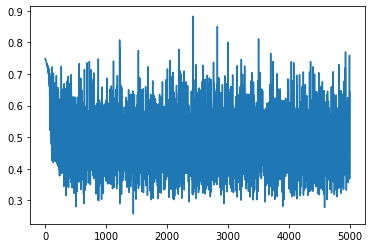

In [26]:
plt.plot(loss)
print(loss.min())
print(loss.max())
K.eval(model.optimizer.lr)

62.0


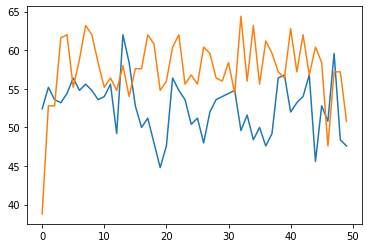

In [27]:
plt.plot(val_acc, label='valid')
plt.plot(train_acc, label='train')
print(best)

In [28]:
print(targets)
print(model.predict_on_batch(inputs))

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
[[0.44125804]
 [0.02520272]
 [0.2256718 ]
 [0.6379007 ]
 [0.467497  ]
 [0.51525843]
 [0.5268966 ]
 [0.65075845]
 [0.50758815]
 [0.49847674]]


In [29]:
(inputs, targets) = get_batch(batch_size, s='val')
print(targets)
print(model.predict_on_batch(inputs))

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
[[0.00601202]
 [0.43845055]
 [0.01539296]
 [0.39542142]
 [0.41427702]
 [0.42244068]
 [0.5268966 ]
 [0.51955396]
 [0.38980025]
 [0.48971742]]


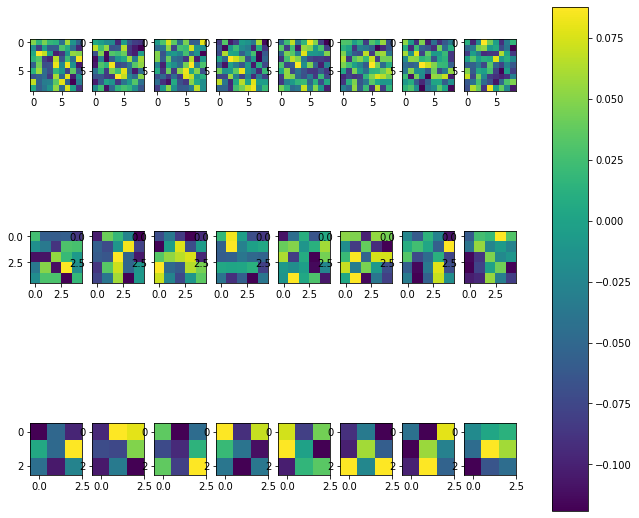

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(10, 10))
for i in range(3):
  for j in range(8):
    im=axs[i, j].imshow(model.layers[2].get_weights()[2 * i][:, :, 0, j])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

<BarContainer object of 256 artists>

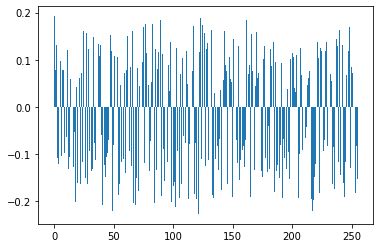

In [31]:
plt.bar(np.arange(model.layers[4].get_weights()[0].shape[0]), model.layers[4].get_weights()[0][:,0])

## Compare with 1-NN based on intensity and K dissimilarity functions

In [0]:
def nearest_neighbour_correct(pairs, targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt((pairs[0][i] - pairs[1][i])**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

def test_nn_accuracy(N_ways, n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    for i in range(n_trials):
        pairs, targets, __, __ = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [33]:
test_nn_accuracy(10, 100)

Evaluating nearest neighbour on 100 unique 10 way one-shot learning tasks ...


10.0

In [0]:
def intensity_distance_correct(targets, cats, inds):
    """returns 1 if intensity distance gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    rho_distances = np.zeros(len(cats))
    for i in range(len(cats)):
        rho_distances[i] = np.sum((sim_rhos[cats[0]][inds[0]] - sim_rhos[cats[i]][inds[1][i]])**2)
    if np.argmin(rho_distances) == np.argmax(targets):
        return 1
    return 0

def test_id_accuracy(N_ways, n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating intensity distance on {} unique {} way one-shot learning tasks ...".format(n_trials, N_ways))

    n_right = 0
    
    for i in range(n_trials):
        __, targets, cat, ind = make_oneshot_task(N_ways,"val")
        correct = intensity_distance_correct(targets, cat, ind)
        n_right += correct
    return 100.0 * n_right / n_trials

In [35]:
test_id_accuracy(10, 100)

Evaluating intensity distance on 100 unique 10 way one-shot learning tasks ...


5.0

In [0]:
def Kfun_distance_correct(targets, cats, inds):
    """returns 1 if intensity distance gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    K_dists = np.zeros(len(cats))
    for i in range(len(cats)):
        #K_dists[i] = np.sum((np.log(1e-12 + sim_Ks[cats[0], inds[0], :]) - np.log(1e-12 + sim_Ks[cats[i], inds[1][i], :]))**2)
        #K_dists[i] = np.sum((np.sqrt(sim_Ks[cats[0], inds[0], :]) - np.sqrt(sim_Ks[cats[i], inds[1][i], :]))**2)
        K_dists[i] = np.sum((sim_Ks[cats[0], inds[0], :] - sim_Ks[cats[i], inds[1][i], :])**2)
    if np.argmin(K_dists) == np.argmax(targets):
        return 1
    return 0

def test_Kf_accuracy(N_ways, n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating K function distance on {} unique {} way one-shot learning tasks ...".format(n_trials, N_ways))

    n_right = 0
    
    for i in range(n_trials):
        __, targets, cat, ind = make_oneshot_task(N_ways,"val")
        correct = Kfun_distance_correct(targets, cat, ind)
        n_right += correct
    return 100.0 * n_right / n_trials

In [0]:
def Kfun_distance_correct2(targets, cats, inds):
    """returns 1 if intensity distance gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    K_dists = np.zeros(len(cats))
    for i in range(len(cats)):
        #K_dists[i] = np.sum((np.log(1e-12 + sim_Ks[cats[0], inds[0], :]) - np.log(1e-12 + sim_Ks[cats[i], inds[1][i], :]))**2)
        #K_dists[i] = np.sum((np.sqrt(sim_Ks[cats[0], inds[0], :]) - np.sqrt(sim_Ks[cats[i], inds[1][i], :]))**2)
        K_dists[i] = np.sum((sim_Ks2[cats[0], inds[0], :] - sim_Ks2[cats[i], inds[1][i], :])**2)
    if np.argmin(K_dists) == np.argmax(targets):
        return 1
    return 0

def test_Kf_accuracy2(N_ways, n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating K function distance on {} unique {} way one-shot learning tasks ...".format(n_trials, N_ways))

    n_right = 0
    
    for i in range(n_trials):
        __, targets, cat, ind = make_oneshot_task(N_ways,"val")
        correct = Kfun_distance_correct(targets, cat, ind)
        n_right += correct
    return 100.0 * n_right / n_trials

In [38]:
test_Kf_accuracy(10, 100)

Evaluating K function distance on 100 unique 10 way one-shot learning tasks ...


33.0

In [39]:
ways = np.arange(2, 11, 1)
resume =  False
trials = 1000

val_accs, train_accs, nn_accs, id_accs, kf_accs, kf2_accs = [], [], [], [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    id_acc = test_id_accuracy(N, trials)
    id_accs.append(id_acc)
    kf_acc = test_Kf_accuracy(N, trials)
    kf_accs.append(kf_acc)
    kf2_acc = test_Kf_accuracy2(N, trials)
    kf2_accs.append(kf2_acc)
    print ("NN Accuracy = ", nn_acc)
    print ("ID Accuracy = ", id_acc)
    print ("KF Accuracy = ", kf_acc)
    print ("KF2 Accuracy = ", kf2_acc)
    print("---------------------------------------------------------------------------------------------------------------")


Evaluating model on 1000 random 2 way one-shot learning tasks ... 

Got an average of 89.5% 2 way one-shot learning accuracy 

Evaluating model on 1000 random 2 way one-shot learning tasks ... 

Got an average of 93.5% 2 way one-shot learning accuracy 

Evaluating nearest neighbour on 1000 unique 2 way one-shot learning tasks ...
Evaluating intensity distance on 1000 unique 2 way one-shot learning tasks ...
Evaluating K function distance on 1000 unique 2 way one-shot learning tasks ...
Evaluating K function distance on 1000 unique 2 way one-shot learning tasks ...
NN Accuracy =  52.4
ID Accuracy =  49.8
KF Accuracy =  81.1
KF2 Accuracy =  80.5
---------------------------------------------------------------------------------------------------------------
Evaluating model on 1000 random 3 way one-shot learning tasks ... 

Got an average of 80.4% 3 way one-shot learning accuracy 

Evaluating model on 1000 random 3 way one-shot learning tasks ... 

Got an average of 87.4% 3 way one-shot le

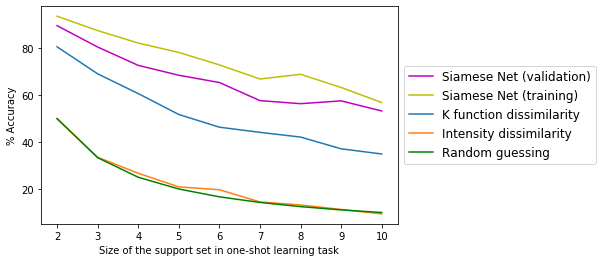

In [40]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(ways, val_accs, "m", label="Siamese Net (validation)")
ax.plot(ways, train_accs, "y", label="Siamese Net (training)")
#plt.plot(ways, nn_accs, label="Nearest neighbour")
#plt.plot(ways, kf_accs, label="K function distance")
plt.plot(ways, kf2_accs, label="K function dissimilarity")
plt.plot(ways, id_accs, label="Intensity dissimilarity")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Size of the support set in one-shot learning task")
plt.ylabel("% Accuracy")
#plt.title("One-Shot Learning Performance for\nSimulated Point Patterns from 10 Processes", 
#          fontsize=15)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.show()

fig.savefig('accuracy.pdf', bbox_inches='tight')

In [0]:
#inputs, targets = make_oneshot_task(8, "val", 'Oriya')
#plot_oneshot_task(inputs)

##Dissimilarity matrix

In [0]:
import seaborn as sn
from scipy.cluster.hierarchy import dendrogram, linkage

In [0]:
pairs = [None] * 2
res1 = np.zeros((n_classes, n_classes))
for i in range(n_classes):
  for j in range(i, n_classes):
    tmp = []
    for k in range(n_examples):
      for l in range(n_examples):
        if ((i != j) or (k != l)):
          pairs[0] =  X[i, k, :, :].reshape(1, grid_ny, grid_nx, 1)
          pairs[1] =  X[j, l, :, :].reshape(1, grid_ny, grid_nx, 1)
          tmp.append(model.predict(pairs))
    tmp = np.asarray(tmp)
    res1[i, j] = res1[j, i] = tmp.mean()

#print(res1)
res1 = pd.DataFrame(res1, index = process, columns = process)

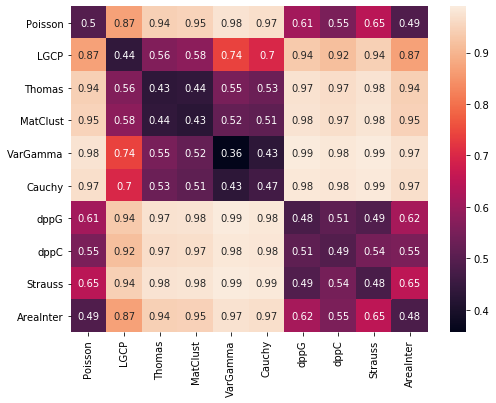

In [44]:
plt.figure(figsize = (8, 6))
svm = sn.heatmap(1 - res1, annot=True)
fig = svm.get_figure()
fig.savefig('cnnconfusion.pdf', bbox_inches='tight')

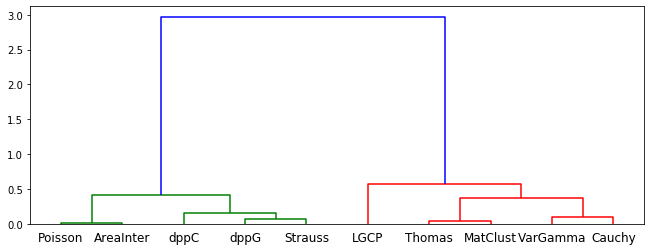

In [45]:
linked = linkage(1 - res1, method='ward')
fig = plt.figure(figsize=(11, 4))
dendrogram(linked, orientation='top', labels=process,
            distance_sort='descending', show_leaf_counts=True)
plt.show()
fig.savefig('hc1.pdf', bbox_inches='tight')
plt.close()

In [0]:
res2 = np.zeros((n_classes, n_classes))
for i in range(n_classes):
  for j in range(i, n_classes):
    tmp = []
    for k in range(n_examples):
      for l in range(k, n_examples):
        if ((i != j) or (k != l)):
          tmp.append(np.mean((sim_Ks[i, k, :] - sim_Ks[j, l, :])**2))
    tmp = np.asarray(tmp)
    res2[i, j] = res2[j, i] =  tmp.mean()

#print(res2)
res2 = pd.DataFrame(res2, index = process, columns = process)

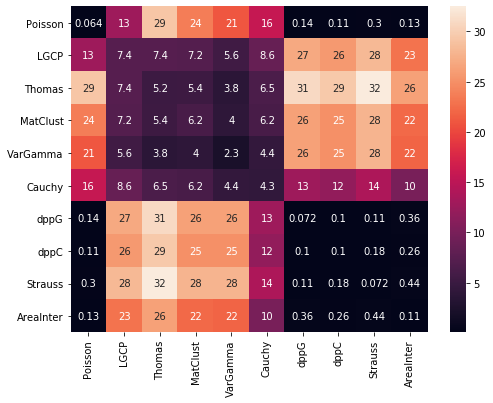

In [47]:
plt.figure(figsize = (8, 6))
svm = sn.heatmap(res2 * 1e05, annot=True)
#plt.show()
fig = svm.get_figure() 
fig.savefig('Kdistmat.pdf', bbox_inches='tight')

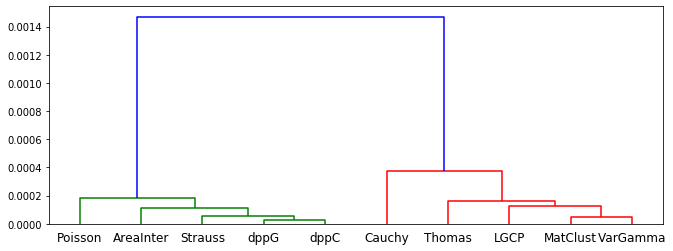

In [48]:
linked = linkage(res2, 'ward')
fig = plt.figure(figsize=(11, 4))
dendrogram(linked, orientation='top', labels=process,
            distance_sort='descending', show_leaf_counts=True)
plt.show()
fig.savefig('hc2.pdf', bbox_inches='tight')

In [49]:
res2 / np.diag(res2)

,Poisson,LGCP,Thomas,MatClust,VarGamma,Cauchy,dppG,dppC,Strauss,AreaInter
Poisson,1.000000,1.744060,5.635958,3.803821,9.300908,3.715992,2.010270,1.067190,4.134118,1.105414
LGCP,200.874266,1.000000,1.417847,1.162070,2.486018,2.011968,375.646941,256.713816,391.743921,200.832740
Thomas,456.841525,0.997848,1.000000,0.862002,1.699904,1.533909,429.630995,293.886538,449.882475,231.075931
MatClust,370.330616,0.982288,1.035333,1.000000,1.770443,1.448058,367.595099,250.320809,385.164240,195.116610
VarGamma,328.363070,0.762027,0.740381,0.642009,1.000000,1.035594,367.089431,249.944738,386.636669,192.445268
Cauchy,247.060105,1.161411,1.258142,0.988882,1.950242,1.000000,177.619506,118.703383,192.166927,87.418049
dppG,2.257426,3.662488,5.951919,4.239937,11.676216,3.000005,1.000000,1.019470,1.551238,3.135458
dppC,1.673117,3.494386,5.684160,4.030991,11.099399,2.799108,1.423311,1.000000,2.438006,2.272146
Strauss,4.667645,3.840204,6.266371,4.466746,12.364854,3.263365,1.559675,1.755760,1.000000,3.824360
AreaInter,1.971646,3.110109,5.084647,3.574610,9.722596,2.345185,4.980187,2.584972,6.041543,1.000000


##Pair correlation function of processes

In [0]:
#import numpy as np
r = np.arange(0, 0.12, 0.0001)
g1 = np.asarray([1] * r.shape[0])
g2 = np.exp(np.exp(-(13.45 * r)**2))
g3 = 1 + (np.exp(1) - 1) * np.exp(-r**2 / 0.004)
g4 = 1 + np.where(r < 0.12, 0.008 * (np.exp(1) - 1) / (np.pi * 0.06**2) * (np.arccos(r / 0.12) - (r / 0.12) * np.sqrt(1 - (r / 0.12)**2)), 0)
g5 = 1 + 0.002 * (np.exp(1) - 1) / (0.025**2) * np.exp(-r / 0.025)
g6 = 1 + 0.002 * (np.exp(1) - 1) / 0.0009 * (1 + r**2 / 0.0009)**(-1.5)
g7 = 1 - np.exp(- 2 * (r / 0.03257)**2)
g8 = 1 - (1 + (r/0.03257)**2)**(-4)

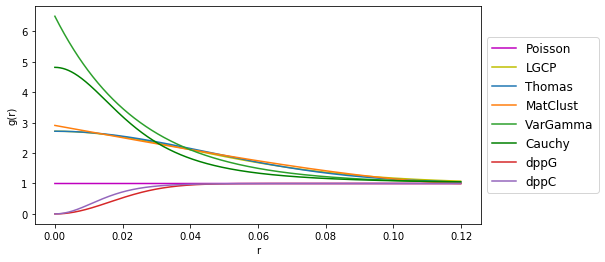

In [51]:
#import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 4))
ax.plot(r, g1, "m", label="Poisson")
ax.plot(r, g2, "y", label="LGCP")
ax.plot(r, g3, label="Thomas")
ax.plot(r, g4, label="MatClust")
ax.plot(r, g5, label="VarGamma")
ax.plot(r, g6, "g", label="Cauchy")
ax.plot(r, g7, label="dppG")
ax.plot(r, g8, label="dppC")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.xscale('linear')
#plt.yscale('log', basey=10)
#plt.title("Piar correlation functions of processes\nused for simulation study", 
#          fontsize=15)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.show()
fig.savefig('pcffuns.pdf', bbox_inches='tight')